In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message=r".*Reordering categories will always return a new Categorical object.*")
warnings.filterwarnings("ignore", category=FutureWarning, message=r".*is_categorical_dtype is deprecated and will be removed in a future version.*")

In [2]:
import atac_networks
import scanpy as sc

In [3]:
?atac_networks.add_region_infos

Signature: atac_networks.add_region_infos(AnnData, sep=('_', '_'), inplace=True)
Docstring:
Get region informations from the var_names of AnnData object.
e.g. chr1_12345_12346 -> 'chromosome' : chr1,
                         'start' : 12345,
                         'end' : 12346
These info will be added to var of AnnData object.
    adata.var['chromosome'] : chromosome
    adata.var['start'] : start position
    adata.var['end'] : end position

Parameters
----------
AnnData : AnnData object
    AnnData object with var_names as region names.
sep : tuple, optional
    Separator of region names. The default is ('_', '_').

Returns
-------
AnnData : AnnData object
    AnnData object with region informations in var.
File:      ~/ATACNet/atac_network/atac_networks/atac_networks.py
Type:      function

In [3]:
import numpy as np
import pandas as pd
import anndata as ad

import scipy as sp
from scipy import linalg
from sklearn.datasets import make_sparse_spd_matrix
import matplotlib.pyplot as plt

# Test with sparse covariance true matrix as GT

In [4]:
# Create fake single-cell atac-seq data
nb_cells = 300
nb_chr = 10
nb_regions_per_chr = 200
between_reg = 2000
size_reg = 50

counts = []
for chr in range(nb_chr):
    counts.append(pd.DataFrame(np.random.randint(0,100, size=(nb_cells, nb_regions_per_chr)),
                        index=['Cell_'+j for j in map(str, range(nb_cells))],
                        columns=['chr'+str(chr)+'_'+str(i)+'_'+str(i+size_reg) for i in range(1, nb_regions_per_chr*between_reg+1, between_reg)]))
atac = ad.AnnData(pd.concat(counts, axis=1))

In [5]:
distance_threshold = 50000

### 1. Add region position in AnnData.obs

In [6]:
atac_networks.add_region_infos(atac)

### 2. Replace random data with fake cov matrix

In [7]:
n_samples, n_features = 300, nb_regions_per_chr

prng = np.random.RandomState(0)
prec = make_sparse_spd_matrix(
    n_features, alpha=0.99, smallest_coef=0.4, largest_coef=0.7, random_state=prng
)
cov = linalg.inv(prec)

#cov with only potential connections
possible_co = sp.sparse.csr_matrix(atac_networks.get_distances_regions(atac)<distance_threshold/2)[:cov.shape[0],:cov.shape[1]]
possible_co = sp.sparse.coo_matrix(possible_co).toarray() + sp.sparse.coo_matrix(possible_co).toarray().T 
cov = np.eye(len(cov))*np.diag(cov) + possible_co*cov 
d = np.sqrt(np.diag(cov))
cov /= d
cov /= d[:, np.newaxis]
prec *= d
prec *= d[:, np.newaxis]
X = prng.multivariate_normal(np.zeros(n_features), cov, size=n_samples)
X -= X.mean(axis=0)
X /= X.std(axis=0)

X_ = np.concatenate([X]*nb_chr, axis=1)
atac.X = np.abs(X_)
atac.X = np.where(X_<0, 0, X_)

### 2.A. Remove Null rows

In [8]:
atac.X

array([[0.2434349 , 0.        , 0.85984224, ..., 0.09995541, 1.02769824,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.49458648, 0.66467403,
        0.17172372],
       [1.9426328 , 0.        , 0.        , ..., 1.77252181, 0.        ,
        1.14206552],
       ...,
       [0.69677106, 0.12009173, 0.        , ..., 0.93369823, 0.87605932,
        1.93807576],
       [0.        , 0.01211488, 0.67042407, ..., 0.        , 0.        ,
        0.71022194],
       [0.25686636, 0.33899131, 0.0842528 , ..., 2.14650815, 0.        ,
        0.        ]])

In [9]:
sc.pp.filter_genes(atac, min_cells=1)

In [10]:
atac

AnnData object with n_obs × n_vars = 300 × 2000
    var: 'chromosome', 'start', 'end', 'n_cells'

### 3 Calculate co-accessibility

In [11]:
final_score = atac_networks.sliding_graphical_lasso(
    atac,
    window_size=distance_threshold,
    unit_distance = 1000,
    distance_constraint=distance_threshold/2,
    n_samples=50,
    n_samples_maxtry=100,
    max_alpha_iteration=60
)

Calculating penalty coefficient alpha...


 55%|███████████████████████████████████████████████████████▌                                             | 55/100 [00:01<00:00, 51.29it/s]


Calculating co-accessibility scores...
chr0 1/2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 693.13it/s]


chr1 1/2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 441.22it/s]


chr2 1/2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 322.14it/s]


chr3 1/2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 333.80it/s]


chr4 1/2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 336.72it/s]


chr5 1/2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 349.82it/s]


chr6 1/2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 335.45it/s]


chr7 1/2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 540.99it/s]


chr8 1/2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 187.31it/s]


chr9 1/2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 543.42it/s]


chr0 2/2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 669.01it/s]


chr1 2/2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 486.71it/s]


chr2 2/2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 498.30it/s]


chr3 2/2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 345.12it/s]


chr4 2/2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 330.32it/s]


chr5 2/2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 383.52it/s]


chr6 2/2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 356.74it/s]


chr7 2/2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 405.75it/s]


chr8 2/2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 417.54it/s]


chr9 2/2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 380.23it/s]


Averaging co-accessibility scores across windows...


### 4. Plot comparison between co-accessibility scores and covariance matrix used to generate the data

0.4475 0.09


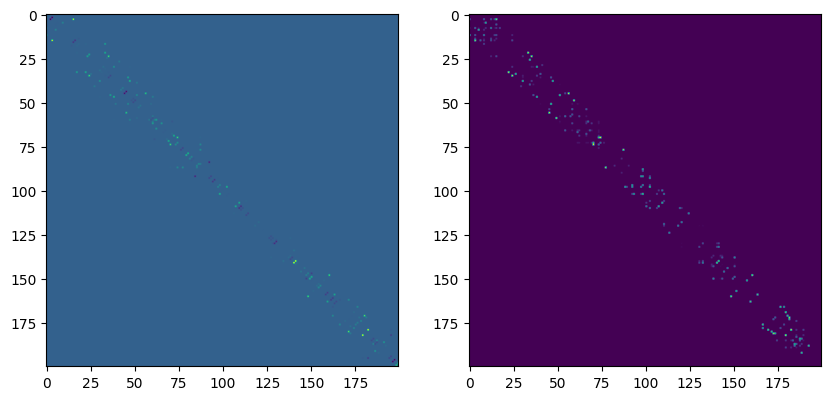

In [13]:
def diag_block_mat_slicing(L):
    shp = L[0].shape
    N = len(L)
    r = range(N)
    out = np.zeros((N,shp[0],N,shp[1]),dtype=int)
    out[r,:,r,:] = L
    return out.reshape(np.asarray(shp)*N)

corrected = final_score.toarray()[:200, :200]
corrected = np.where(corrected <= 0, corrected, corrected)
corrected = corrected - np.diag(corrected)*np.eye(len(cov))

cov_ = cov - np.diag(cov)*np.eye(len(cov))

fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(corrected)
ax[1].imshow(np.where(cov_<=0, cov_, cov_))


print((cov_[:20,:20]>0).sum()/(400), (corrected[:20,:20]>0).sum()/(400), )

0.53 0.01


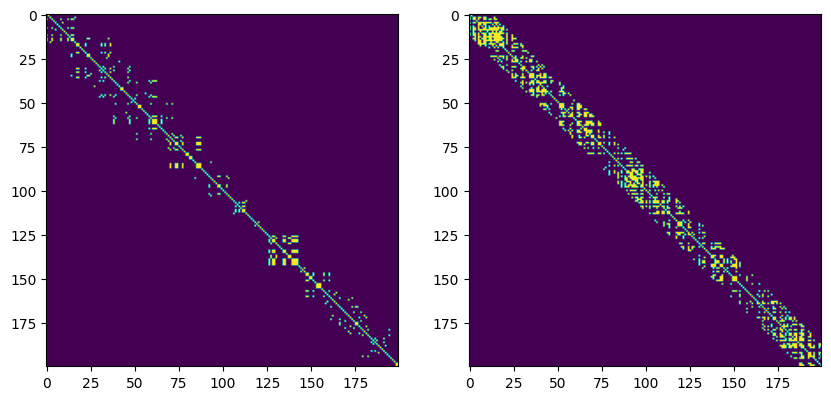

In [14]:
corrected = final_score.toarray()[:200, :200]
corrected = np.where(corrected <= 0, 0, 1)


fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(corrected)
ax[1].imshow(np.where(cov<=0, 0, 1))

print((cov[:10,:10]>0).sum()/(100), (corrected[10,10]>0).sum()/(100), )

In [14]:
atac_networks.lsi(atac)

/home/rtrimbou/miniconda3/envs/atac_networks/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


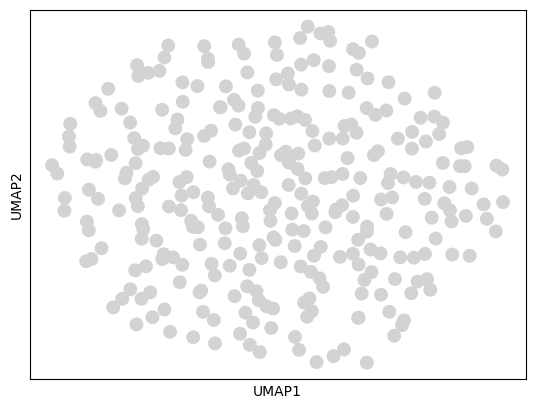

In [19]:
sc.pp.neighbors(atac, use_rep="X_lsi", metric="cosine")
sc.tl.umap(atac)

sc.pl.umap(atac)

In [68]:
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

In [1]:
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

def compute_metacells(atac, k=50, max_overlap_metacells=0.9, max_metacells=5000, dim_reduction='lsi', projection='umap', method='mean'):
    
    atac_networks.lsi(atac)
    sc.pp.neighbors(atac, use_rep="X_lsi", metric="cosine")
    sc.tl.umap(atac)

    # Identify non-overlapping above a threshold metacells
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='kd_tree').fit(atac.obsm['X_umap'])
    distances, indices = nbrs.kneighbors(atac.obsm['X_umap'])
    indices = [set(indice) for indice in indices]

    # Select metacells that doesn't overlap too much (percentage of same cells of origin  < max_overlap_metacells for each pair)
    metacells = [indices[0]]
    iterations = 0
    for i in tqdm(indices[1:]):
        if iterations >= max_metacells-1:
            break
            
        no_overlap = True
        for metacell in metacells:
            if len(metacell.intersection(i)) >= max_overlap_metacells * k:
                no_overlap = False
                break
        if no_overlap:
            metacells.append(i)

        iterations+=1
    
    # Sum expression of neighbors composing the metacell
    metacells_values = []
    for metacell in metacells:
        if method == 'mean':
            metacells_values.append(
                np.mean([atac.X[i] for i in metacell], 0)
            )
        if method == 'sum':
            metacells_values.append(
               sum([atac.X[i] for i in metacell])
            )

    
    # Create a new AnnData object from it 
    metacells_anndata = ad.AnnData(np.array(metacells_values))
    metacells_anndata.var_names = atac.var_names
    # atac_networks.add_region_infos(metacells_anndata)
    
    return metacells_anndata

In [220]:
metacells_atac = compute_metacells(atac, max_overlap_metacells=0.9)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 299/299 [00:00<00:00, 15694.65it/s]


In [221]:
metacells_atac

AnnData object with n_obs × n_vars = 126 × 2000